In [1]:
import json
import os

import tqdm
import pandas as pd

import src.data.Dataset as dt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [3]:
DATASET_PATH = os.path.abspath("./dataset/emptyNonEmptyDatasetCropped")

TRAIN_CSV = os.path.abspath("./data/interim/train/20Train.csv")
VALIDATION_CSV = os.path.abspath("./data/interim/validation/20Validation.csv")
TEST_CSV = os.path.abspath("./data/interim/test/20Test.csv")

RESULT_CSV = os.path.abspath("./reports/model_coberture/60_images_md_v5a.csv")

print(f"DATASET_PATH:   {DATASET_PATH}")
print(f"TRAIN_CSV:      {TRAIN_CSV}")
print(f"VALIDATION_CSV: {VALIDATION_CSV}")
print(f"TEST_CSV:       {TEST_CSV}")
print(f"RESULT_JSON:    {RESULT_CSV}")


DATASET_PATH:   /Users/carlos/WORKSPACE/MegaClassifier/dataset/emptyNonEmptyDatasetCropped
TRAIN_CSV:      /Users/carlos/WORKSPACE/MegaClassifier/data/interim/train/20Train.csv
VALIDATION_CSV: /Users/carlos/WORKSPACE/MegaClassifier/data/interim/validation/20Validation.csv
TEST_CSV:       /Users/carlos/WORKSPACE/MegaClassifier/data/interim/test/20Test.csv
RESULT_JSON:    /Users/carlos/WORKSPACE/MegaClassifier/reports/model_coberture/60_images_md_v5a.csv


In [4]:
threshold = 0.013

result_csv = dt.load_from_csv(RESULT_CSV)
result_filtered = result_csv[result_csv['threshold'] == threshold]
positives = result_filtered[result_filtered['detector_label'] == 1]

The file /Users/carlos/WORKSPACE/MegaClassifier/reports/model_coberture/60_images_md_v5a.csv has been successfully opened.


In [5]:
train_csv = dt.load_from_csv(TRAIN_CSV)
vali_csv = dt.load_from_csv(VALIDATION_CSV)
test_csv = dt.load_from_csv(TEST_CSV)

The file /Users/carlos/WORKSPACE/MegaClassifier/data/interim/train/20Train.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/interim/validation/20Validation.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/interim/test/20Test.csv has been successfully opened.


In [6]:
columns = ['file_name', 'label']

# data = []
# for _, row in positives.iterrows():
#     file_name = os.path.join(DATASET_PATH, row['file_name'])
#     label = row['label']
#     data.append([file_name, label])
    
# train_dataset = pd.DataFrame(data, columns=columns)
# train_dataset['label'] = train_dataset['label'].astype(str)

data = []
for _, row in train_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row['file_name'])
    label = row['label']
    data.append([file_name, label])
train_dataset = pd.DataFrame(data, columns=columns)
train_dataset['label'] = train_dataset['label'].astype(str)

data = []
for _, row in vali_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row['file_name'])
    label = row['label']
    data.append([file_name, label])
vali_dataset = pd.DataFrame(data, columns=columns)
vali_dataset['label'] = vali_dataset['label'].astype(str)

data = []
for _, row in test_csv.iterrows():
    file_name = os.path.join(DATASET_PATH, row['file_name'])
    label = row['label']
    data.append([file_name, label])
test_dataset = pd.DataFrame(data, columns=columns)
test_dataset['label'] = test_dataset['label'].astype(str)

img_weight = 224
img_height = 224

batch_size = 8

seed = 42

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    rotation_range=20,         # Rotar la imagen entre -20 y 20 grados
    width_shift_range=0.2,     # Desplazamiento horizontal de hasta el 20% de la imagen
    height_shift_range=0.2,    # Desplazamiento vertical de hasta el 20% de la imagen
    zoom_range=0.2,            # Zoom in/out de hasta el 20%
    shear_range=0.2,           # Aplicar deformaciones en la imagen
    brightness_range=[0.8, 1.2]# Cambios de brillo entre 80% y 120%
)
datagen_val_test = ImageDataGenerator(rescale=1.0 / 255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=seed,
)

val_generator = datagen_val_test.flow_from_dataframe(
    dataframe=vali_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=seed,
)

test_generator = datagen_val_test.flow_from_dataframe(
    dataframe=test_dataset,
    x_col="file_name",
    y_col="label",
    target_size=(img_weight, img_height),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False,
)

# Cargar el modelo preentrenado sin las capas de salida
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_weight, img_height, 3))
base_model = MobileNetV2(include_top=False, input_shape=(img_weight, img_height, 3))

# Congelar las capas del modelo base
base_model.trainable = True

# Crear el modelo final con capas adicionales
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Alternativa a Flatten
    Dense(1, activation='sigmoid')  # Clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()

# Definir el callback para guardar el mejor modelo basado en la menor pérdida de validación
checkpoint = ModelCheckpoint('best_model_resnet50.h5', 
                             monitor='val_loss',  # Monitoreamos la pérdida en validación
                             save_best_only=True,  # Guardamos solo el mejor modelo
                             mode='min',           # Queremos minimizar la pérdida
                             verbose=1)            # Muestra un mensaje cada vez que guarda
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitoreamos la pérdida de validación
    patience=5,          # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar el mejor modelo
)

# Entrenar el modelo con el callback de checkpoint
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=val_generator,
    # validation_steps=val_generator.samples // batch_size,  # Ajusta batch_size correctamente
    # validation_steps = max(1, val_generator.samples // batch_size),
    validation_steps = val_generator.samples // batch_size if val_generator.samples % batch_size == 0 else (val_generator.samples // batch_size) + 1,
    callbacks=[checkpoint]
)

Found 42 validated image filenames belonging to 2 classes.
Found 9 validated image filenames belonging to 2 classes.
Found 9 validated image filenames belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
________________________________________________________________

2024-09-24 19:34:34.054499: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.7059
Epoch 1: val_loss improved from inf to 0.46866, saving model to best_model_resnet50.h5
5/5 [==============================] - 3s 291ms/step - loss: 0.6360 - accuracy: 0.7059 - val_loss: 0.4687 - val_accuracy: 0.8889
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 0.5838 - accuracy: 0.8529
Epoch 2: val_loss did not improve from 0.46866
5/5 [==============================] - 1s 200ms/step - loss: 0.5838 - accuracy: 0.8529 - val_loss: 3.4763 - val_accuracy: 0.6667
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8529
Epoch 3: val_loss did not improve from 0.46866
5/5 [==============================] - 1s 213ms/step - loss: 0.3379 - accuracy: 0.8529 - val_loss: 2.4808 - val_accuracy: 0.6667
Epoch 4/50
5/5 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.8235
Epoch 4: val_loss did not improve from 0.46866
5/5 [=======================

In [7]:
from tensorflow.keras.models import load_model

# Cargar el mejor modelo guardado durante el entrenamiento
best_model = load_model('best_model_resnet50.h5')

# Evaluar o usar el mejor modelo
model.evaluate(test_generator)

2/2 [==============================] - 0s 11ms/step - loss: 3.2037 - accuracy: 0.5556


[3.2036983966827393, 0.5555555820465088]

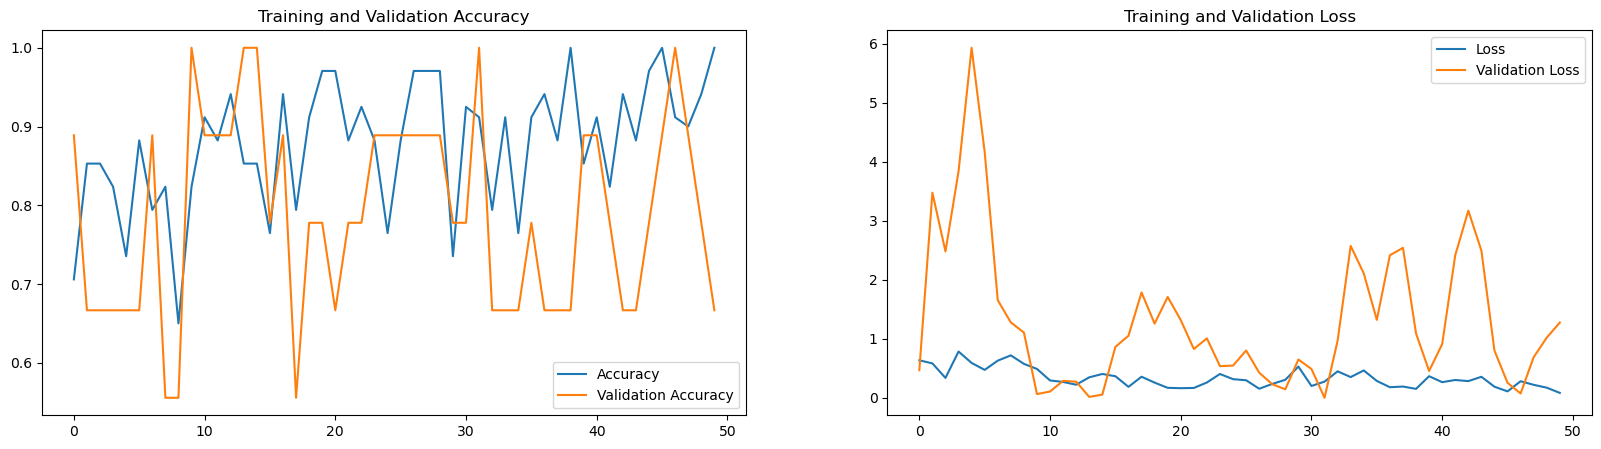

In [8]:
import matplotlib.pyplot as plt

# Graficar la precisión y pérdida en entrenamiento y validación
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Llamar a la función para graficar
plot_training_history(history)

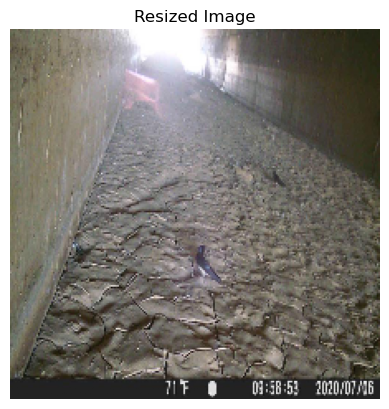

In [12]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Cargar una imagen desde un archivo
img_path = '/Users/carlos/WORKSPACE/MegaClassifier/dataset/emptyNonEmptyDataset/ave/2_ave_alumno_1_TH/Ave (1)_frame050.jpg'
img = Image.open(img_path)
img = np.array(img).astype(float) / 255

# Redimensionar la imagen a 224x224
img_resize = cv2.resize(img, (224, 224))

plt.imshow(img_resize)
plt.title('Resized Image')
plt.axis('off')
plt.show()
